In [ ]:
#Mounting the Goodgle Drive to access the drive contents
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pyLDAvis


In [ ]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models
import gensim
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')
from collections import defaultdict, Counter
import string
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).ep

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# **EDA**

In [ ]:
# load train data
train = pd.read_csv('/content/gdrive/MyDrive/Sachin : CAIR Internship/Datasets and Code/train.csv')
train.head()

id  ... label
0   0  ...     1
1   1  ...     0
2   2  ...     1
3   3  ...     1
4   4  ...     1

[5 rows x 5 columns]

In [ ]:
#The total records and columns of the dataset
train.shape

(20800, 5)

In [ ]:
#train information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
#checking for missing values
train.isnull().values.any()

True

In [ ]:
#checking for missing values
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
# using dropna() function  
train = train.dropna()

In [ ]:
#checking for missing values after dropping
train.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
#checking for duplicates
train.duplicated().sum()

0

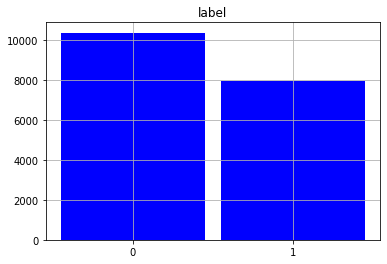

In [ ]:
# Class balance analysis
train[['label']].hist(bins = 3)
plt.bar(np.arange(len([0,1])), train.groupby(['label']).size().values, 0.9,  color="blue")
plt.xticks(np.arange(len([0,1])), [0,1])
plt.show()

In [ ]:
train['label'].value_counts()

0    10361
1     7924
Name: label, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea78938f10>,
      dtype=object)

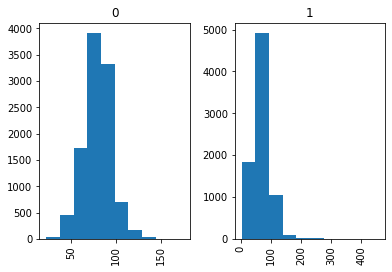

In [ ]:
#  the number of characters present in each title by labels
train['title'].str.len().hist(by=train['label'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea7838e390>,
      dtype=object)

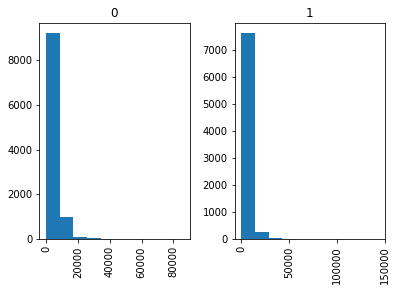

In [ ]:
#  the number of characters present in each text by labels
train['text'].str.len().hist(by=train['label'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea7835a190>,
      dtype=object)

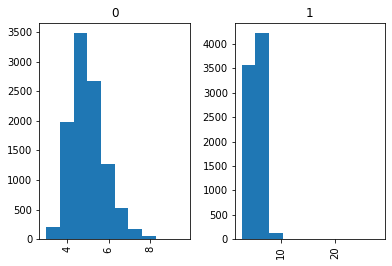

In [ ]:
# Word level analysis of title
#Number of words appearing in each new’s title
train['title'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=train['label'])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea3f9e15d0>,
      dtype=object)

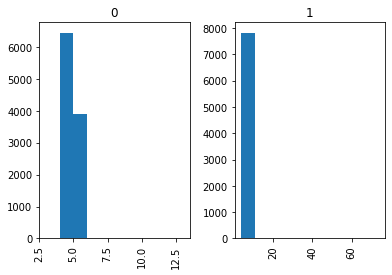

In [ ]:
# Word level analysis of title
#Number of words appearing in each new’s text
train['text'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=train['label'])

****Word frequency without stop words****

In [ ]:
# Remove stopwords from title and text by label
messages_fake=train[train.label==1].copy()
messages_not_fake=train[train.label==0].copy()

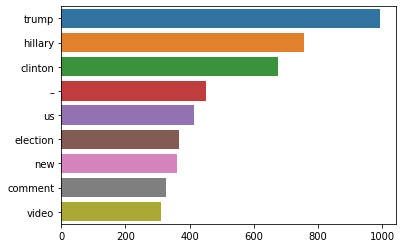

In [ ]:
# Corpus analysis corpus_title_fake
stop=set(stopwords.words('english'))
messages_fake['title'] = messages_fake['title'].str.lower()
messages_fake['title'] = messages_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_fake['title'].str.split()
new=new.values.tolist()
corpus_title_fake=[word for i in new for word in i]

counter=Counter(corpus_title_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:25]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

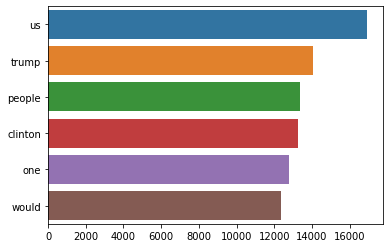

In [ ]:
# Corpus analysis corpus_text_fake
stop=set(stopwords.words('english'))
messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_fake['text'].str.split()
new=new.values.tolist()
corpus_text_fake=[word for i in new for word in i]

counter=Counter(corpus_text_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

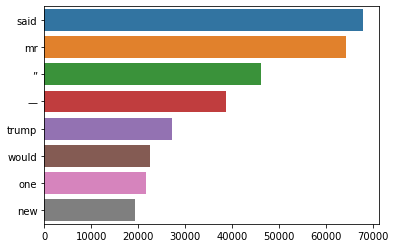

In [ ]:
# Corpus analysis corpus_title_not_fake
stop=set(stopwords.words('english'))
messages_not_fake['title'] = messages_not_fake['text'].str.lower()
messages_not_fake['title'] = messages_not_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_not_fake['title'].str.split()
new=new.values.tolist()
corpus_title_not_fake=[word for i in new for word in i]

counter=Counter(corpus_title_not_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

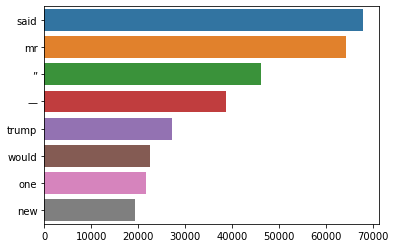

In [ ]:
# Corpus analysis corpus_text_not_fake
stop=set(stopwords.words('english'))
messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = messages_not_fake['text'].str.split()
new=new.values.tolist()
corpus_text_not_fake=[word for i in new for word in i]

counter=Counter(corpus_text_not_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

The corpus of title and text of fake and not fake news is different and the order of the words is also different.


In [ ]:
# Ngram analysis function

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.

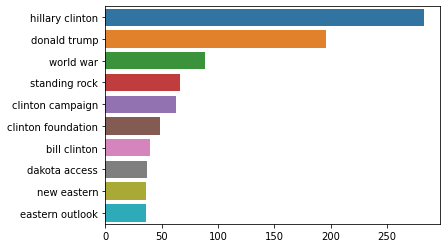

In [ ]:
# Ngram analysis corpus_title_fake
messages_fake['title'] = messages_fake['title'].str.lower()
messages_fake['title'] = messages_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_fake['title'] = messages_fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_fake['title'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

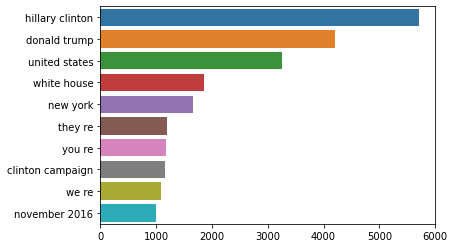

In [ ]:
# Ngram analysis corpus_text_fake

messages_fake['text'] = messages_fake['text'].str.lower()
messages_fake['text'] = messages_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_fake['text'] = messages_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

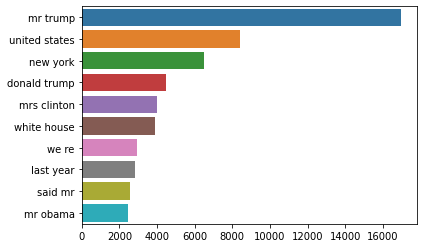

In [ ]:
# Ngram analysis corpus_title_not_fake

messages_not_fake['title'] = messages_not_fake['title'].str.lower()
messages_not_fake['title'] = messages_not_fake.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_not_fake['title'] = messages_not_fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_not_fake['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

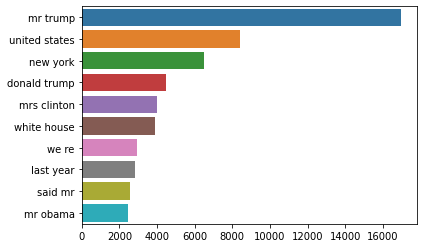

In [ ]:
# Ngram analysis corpus_text_not_fake

messages_not_fake['text'] = messages_not_fake['text'].str.lower()
messages_not_fake['text'] = messages_not_fake.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
messages_not_fake['text'] = messages_not_fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(messages_not_fake['text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

Here we can see that text and title in fake news Ngrams are different, but not fake news/real news is the same.


**LDA**

In [ ]:
#  Preprocess function for LDA
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df,column):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df[column]:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#LDA for corpus_title_fake
corpus = preprocess_news(messages_fake,'title')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.018*"war" + 0.012*"world" + 0.012*"trump" + 0.011*"russia" + 0.009*"new" + 0.005*"comment" + 0.004*"medium" + 0.004*"putin" + 0.004*"russian" + 0.004*"video"'),
 (1,
  '0.008*"hillary" + 0.007*"obama" + 0.005*"police" + 0.005*"muslim" + 0.004*"comment" + 0.004*"like" + 0.004*"clinton" + 0.003*"water" + 0.003*"show" + 0.003*"american"'),
 (2,
  '0.034*"trump" + 0.026*"clinton" + 0.026*"hillary" + 0.015*"election" + 0.010*"fbi" + 0.009*"email" + 0.007*"video" + 0.006*"donald" + 0.006*"vote" + 0.006*"new"'),
 (3,
  '0.007*"hillary" + 0.005*"woman" + 0.004*"comment" + 0.004*"trump" + 0.004*"video" + 0.003*"access" + 0.003*"dakota" + 0.003*"pipeline" + 0.003*"clinton" + 0.003*"2016"')]

In [ ]:
#Vizual for corpus_title_fake
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_fake_title.html')
pyLDAvis.display(vis)

In [ ]:
#LDA for corpus_title_not_fake
corpus = preprocess_news(messages_not_fake,'title')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_not_fake_title.html')
lda_model.show_topics()
pyLDAvis.display(vis)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
#LDA for corpus_text_fake
corpus = preprocess_news(messages_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_fake_text.html')
lda_model.show_topics()
pyLDAvis.display(vis)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
#LDA for corpus_text_not_fake
corpus = preprocess_news(messages_not_fake,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
pyLDAvis.save_html(vis, 'lda_not_fake_text.html')
lda_model.show_topics()
pyLDAvis.display(vis)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
# Function for word cloud
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

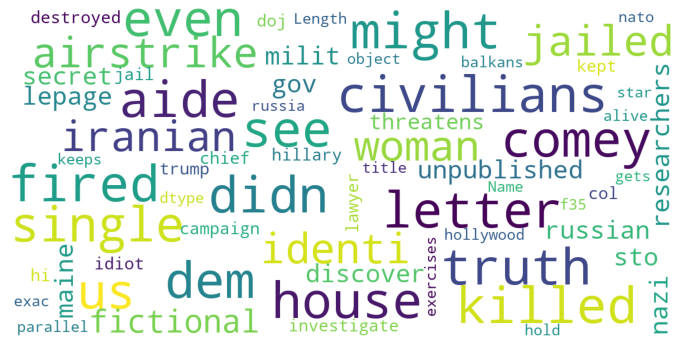

In [ ]:
# Word cloud for corpus_title_fake
show_wordcloud(messages_fake['title'])

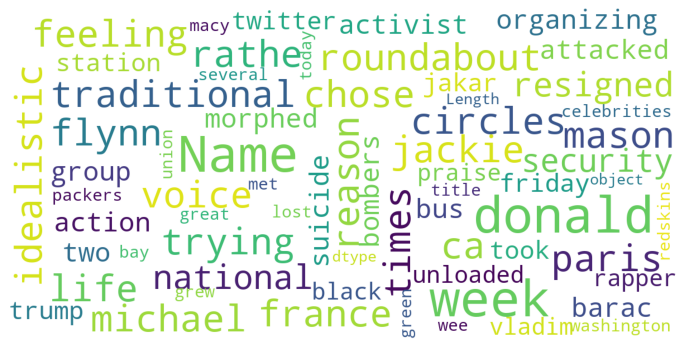

In [ ]:
# Word cloud for corpus_title_not_fake
show_wordcloud(messages_not_fake['title'])

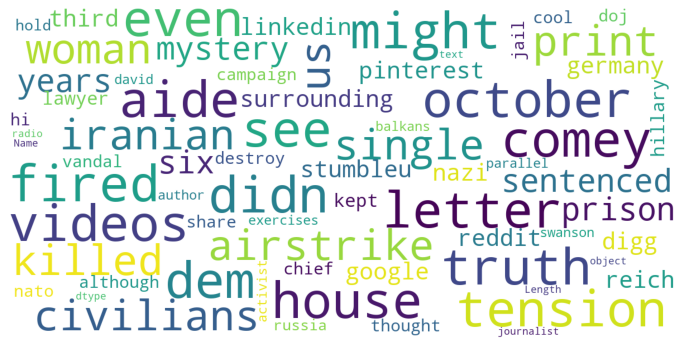

In [ ]:
# Word cloud for corpus_text_fake
show_wordcloud(messages_fake['text'])

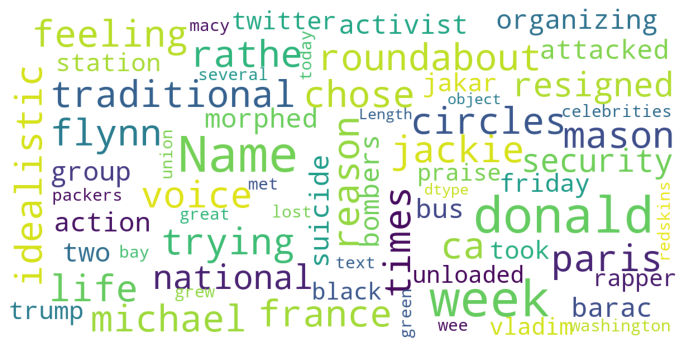

In [ ]:
# Word cloud for corpus_text_not_fake
show_wordcloud(messages_not_fake['text'])

In the above word cloud results, we can see how often some words used in the new’s the title and text in fake or not fake news.